# BERT base neuralmind, soma dos score do par.

## Conceptnet-hypernym-all-relations
- (1,1) é um par onde hipônimo e hiperônimo são de tamanho 1
- O tamanho do par (1,1) será 2, assim como o tamanho do par (2,1) e (1,2) será 3

> Suponha o par (3,2) (abacate, fruta)
> Temos as seguintes sentenças:
- [MASK] ca te é um tipo de fru ta
- aba [MASK] te é um tipo de fru ta
- aba ca [MASK] é um tipo de fru ta
- aba ca te é um tipo de [MASK] ta
- aba ca te é um tipo de fru [MASK]

> Mascarando a palavra e pegando o score dela. O score pra esse par será a soma de todos os valores recuperados.


In [13]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import os

sns.set(style="whitegrid")
plt.clf()
method_names = {'word2vec': 'Word2vec C', 'summation_dot_product': 'DIVE \u0394S * C ', 'dot_product': 'DIVE C',
                'rnd': 'random', 'summation': 'DIVE \u0394S', 'summation_word2vec': 'DIVE \u0394S * Word2vec C',
                'all_subword mean_positional_rank': 'BERT Mean Pos Rank', 'all_subword min_positional_rank': 'BERT Min Pos Rank',
                'all_subword max_pattern': 'BERT Max Pattern', 'all_subword mean_pattern': 'BERT Mean Pattern',
                'min score_final_log(z)': 'BERT Min Pos Rank (log(z))', 'min score_final_norm': 'BERT Min Pos Rank (/ norm)',
                'mean score_final_log(z)': 'BERT Mean Pos Rank (log(z))', 'mean score_final_norm': 'BERT Mean Pos Rank (/ norm)'}

# data
# path_file_bert = "../aaaaaaaa/test_neuralmind-bert-base-portuguese-cased/TESTE.json"
path_file_bert = "../teste/neuralmind-bert-base-portuguese-cased_bert-score_n-subtoken/conceptnet-hypernym-allrelation.json"

f_in = open(path_file_bert)
json_data = json.load(f_in)
def create_dataframe(json_dict):
    dict_values = {'hiponimo': [], 'hiperonimo':[], 'classe':[], 'fonte':[], 'pattern': [], 'soma_hipo':[], 'soma_hiper':[], 'len_hipo':[], 'len_hiper':[]}
    for data, values in json_dict.items():
        hipo, hiper, classe, fonte = data.strip().split()
        for pattern, score in values.items():
            dict_values['hiponimo'].append(hipo)
            dict_values['hiperonimo'].append(hiper)
            dict_values['classe'].append(classe)
            dict_values['fonte'].append(fonte)
            dict_values['pattern'].append(pattern)
            soma = sum(score[0])
            dict_values['soma_hipo'].append(soma)
            soma = sum(score[1])
            dict_values['soma_hiper'].append(soma)
            dict_values['len_hipo'].append(len(score[0]))
            dict_values['len_hiper'].append(len(score[1]))

    df = pd.DataFrame(dict_values)
    df['bert_soma_total'] = df['soma_hipo'] + df['soma_hiper']
    df['len_total'] = df['len_hipo'] + df['len_hiper']
    return df


def filter_by_vocab(path_vocab, dict_data):
    wiki_name = path_vocab.split("/")[-2][9:]
    new_data = {}
    vocab = []
    for line in open(path_vocab):
        w, c = line.strip().split()
        vocab.append(w)
    vocab = set(vocab)

    for k, v in dict_data.items():
        hipo, hyper, _, _ = k.strip().split()
        if hipo in vocab and hyper in vocab:
            new_data[k] = v.copy()
    return new_data

vocabs = ["../vocabs/wikipedia15M/vocab.txt",
          "../vocabs/wikipedia30M/vocab.txt",
          "../vocabs/wikipedia60M/vocab.txt",
          "../vocabs/wikipedia120M/vocab.txt",
          "../vocabs/wikipedia240M/vocab.txt"]
path_d_w = ["/home/gabrielescobar/Documentos/dive-pytorch/results/wikipedia-datasets-test/wikipedia240M_W10_neg15_e15_lr1e-03_eps1e-08_emb100_batch128_runX_not_oov/_result_models_model-wikipedia240M_W10_neg15_e15_lr1e-03_eps1e-08_emb100_batch128_runX_dataset_.-datasets.tsv",
            "/home/gabrielescobar/Documentos/dive-pytorch/results/wikipedia-datasets-test/wikipedia240M_W10_neg15_e15_lr1e-03_eps1e-08_emb100_batch128_runX/_result_models_model-wikipedia240M_W10_neg15_e15_lr1e-03_eps1e-08_emb100_batch128_runX_dataset_.-datasets.tsv"]
df_dive_word2vec = pd.read_csv(path_d_w[0], delimiter="\t")
df_dive_word2vec = df_dive_word2vec[df_dive_word2vec['epoch_num'] == 14]
# df_15 = create_dataframe(filter_by_vocab(vocabs[0], json_data))
# df_30 = create_dataframe(filter_by_vocab(vocabs[1], json_data))
# df_60 = create_dataframe(filter_by_vocab(vocabs[2], json_data))
# df_120 = create_dataframe(filter_by_vocab(vocabs[3], json_data))
df_240 = create_dataframe(filter_by_vocab(vocabs[4], json_data))
df_with_oov = create_dataframe(json_data)


pattern_unique = df_with_oov['pattern'].unique().tolist()
len_total_unique = df_with_oov['len_total'].unique().tolist()

# print(f"DF 15 = {df_15[df_15['pattern'] == pattern_unique[0]].count()['hiponimo']}")
# print(f"DF 30 = {df_30[df_30['pattern'] == pattern_unique[0]].count()['hiponimo']}")
# print(f"DF 60 = {df_60[df_60['pattern'] == pattern_unique[0]].count()['hiponimo']}")
# print(f"DF 120 = {df_120[df_120['pattern'] == pattern_unique[0]].count()['hiponimo']}")
print(f"DF 240 = {df_240[df_240['pattern'] == pattern_unique[0]].count()['hiponimo']}")
print(f"DF all with OOV = {df_with_oov[df_with_oov['pattern'] == pattern_unique[0]].count()['hiponimo']}")


# verificar balanceamento True/False
def balanceamento(df, len_size):
    df_rate = df[df['pattern'] == pattern_unique[0]][['hiponimo', 'hiperonimo', 'classe', 'fonte', 'len_total']]
    df_rate = df_rate.groupby(['len_total'])['classe'].value_counts()

    dict_values = {'len_total': [], 'true':[], 'false':[]}
    for v in len_size:
        if v in df_rate:
            dict_values['len_total'].append(v)
            if "True" in df_rate[v]:
                dict_values['true'].append(df_rate[v]['True'])
            else:
                dict_values['true'].append(0)
            if "False" in df_rate[v]:
                dict_values['false'].append(df_rate[v]['False'])
            else:
                dict_values['false'].append(0)
        else:
            print(f"Balanceamento: {v} não está no dataframe!")

    df_taxa = pd.DataFrame(dict_values)
    # return df_taxa
    df_taxa['ratio'] = df_taxa['true'] / (df_taxa['true'] + df_taxa['false'])
    return df_taxa

df_taxa = balanceamento(df_with_oov, len_size=len_total_unique)

#logsumexp para cada tamanho subtoken e normalização
def logsumexp_normalization(df_data, len_list, pattern_list):
    df = df_data.copy()
    log_store = {}
    logsumexp_store = {}
    normalization = {}
    for size in len_list:
        log_store[size] = {}
        logsumexp_store[size] = {}
        normalization[size] = {}
        for p in pattern_list:
            if p in log_store:
                raise ValueError
            values = df[(df.pattern == p) & (df.len_total == size)]
            log_store[size][p] = torch.tensor(values['bert_soma_total'].tolist())
            logsumexp_store[size][p] = torch.logsumexp(log_store[size][p], dim=0)
            normalization[size][p] = torch.sum(log_store[size][p])

    df['log(Z)'] = df.apply(lambda row: logsumexp_store[row['len_total']][row['pattern']].item(), axis=1)
    df['sum_bert_by_tokensize'] = df.apply(lambda row: normalization[row['len_total']][row['pattern']].item(), axis=1)
    return df

df_with_oov = logsumexp_normalization(df_with_oov, len_list=len_total_unique, pattern_list=pattern_unique)
#score final soma_total - log(Z)

df_with_oov['score_final_log(z)'] = df_with_oov['bert_soma_total'] - df_with_oov['log(Z)']
df_with_oov['score_final_norm'] = df_with_oov['bert_soma_total'] / df_with_oov['sum_bert_by_tokensize']


DF 240 = 14330
DF all with OOV = 30474


<Figure size 432x288 with 0 Axes>

In [14]:
def compute_dataframe_AP_by_pattern(df, key_sort, pattern_list):
    ap_by_pattern = {}
    for p in pattern_list:
        prec_list = []
        df_sorted = df[df['pattern'] == p]
        df_sorted = df_sorted.sort_values(by=key_sort, ascending=False)
        hyper_num = 0
        total_pair = 0
        for row in df_sorted.itertuples():
            total_pair += 1
            if row.fonte == 'hyper':
                hyper_num += 1
                prec_list.append(hyper_num / float(total_pair))

        ap_by_pattern[p] = np.mean(prec_list)
    return pd.DataFrame(data={'padrao': pattern_unique, 'AP': list(ap_by_pattern.values())})

# compute ap in sorted list
def compute_AP(sorted_list):
    prec_list = []
    hyper_num = 0
    total_pair = 0
    for row in sorted_list:
        total_pair += 1
        hyper = row[0].strip().split()[3]
        if hyper == 'hyper':
            hyper_num += 1
            prec_list.append(hyper_num / float(total_pair))
    return np.mean(prec_list)

def compute_AP_by_rank(df, key_sort, best_patterns):
    rank = {}
    # compute rank
    for p in best_patterns:
        df_sorted = df[df['pattern'] == p]
        df_sorted = df_sorted.sort_values(by=key_sort, ascending=False, ignore_index=True)
        for row in df_sorted.itertuples():
            name  = f"{row.hiponimo} {row.hiperonimo} {row.classe} {row.fonte}"
            if name in rank:
                rank[name].append(row.Index)
            else:
                rank[name] = []
                rank[name].append(row.Index)

    mean_rank = {}
    for row in rank:
        if row in mean_rank:
            raise ValueError
        mean_rank[row] = np.mean(rank[row])

    min_rank = {}
    for row in rank:
        if row in min_rank:
            raise ValueError
        min_rank[row] = min(rank[row])
    # del rank
    sort_mean_rank = sorted(mean_rank.items(), key=lambda x: x[1])
    sort_min_rank = sorted(min_rank.items(), key=lambda x: x[1])
    # del mean_rank, min_rank
    mean_ap = compute_AP(sort_mean_rank)
    min_ap = compute_AP(sort_min_rank)

    return min_ap, mean_ap

### AP para cada pattern
- Existem 2 score final
 > Soma BERT - log(Z), sendo log(Z) o logsumexp das somas do BERT para um determinado tamanho de subtoken e padrão.

 > Soma BERT / Soma de todos os BERT, este ultimo usando somente os BERT de mesmo tamanho de subtoken e padrao.

In [15]:
# # AP por pattern com oov
# # ap usando bert_sum - log(Z)
#
# df_ap = compute_dataframe_AP_by_pattern(df_with_oov, key_sort="score_final_log(z)", pattern_list=pattern_unique)
# plt.figure(figsize=(15,8))
# ax = sns.barplot(data=df_ap, x='padrao', y='AP')
# ax.set(xlabel="Padrão")
# ax.set_title(f"BERT AP por padrão. Score final é a soma do BERT - log(Z)")
# plt.xticks(rotation=75)
# plt.show()
# print(f"Melhores padrões usando score_final_log(Z)")
# best_pattern_logz = df_ap.sort_values(by='AP', ascending=False)['padrao'].tolist()
# print(best_pattern_logz)

In [16]:
# # AP por pattern sem oov
# # ap usando bert_sum / sum(bert_sum_tokensize)
# df_view = df_with_oov[df_with_oov['pattern'] == pattern_unique[0]]
#
# df_ap = compute_dataframe_AP_by_pattern(df_with_oov, key_sort="score_final_norm", pattern_list=pattern_unique)
# plt.figure(figsize=(15,8))
# ax = sns.barplot(data=df_ap, x='padrao', y='AP')
# ax.set(xlabel="Padrão")
# ax.set_title(f"BERT AP por padrão. Score final é a soma do BERT normalizado")
# plt.xticks(rotation=75)
# plt.show()
# print(f"Melhores padrões usando score_final_norm")
# best_pattern_norm = df_ap.sort_values(by='AP', ascending=False)['padrao'].tolist()
# print(best_pattern_norm)

## Comparando BERT com DIVE e Word2Vec SEM OOV

### Dataset conceptnet-1
- Usando Wikipedia240M
- N= 14330
- Usando 4 melhores padrões

DF 240 True= 1219
False= 13111
% True= 0.08506629448709002


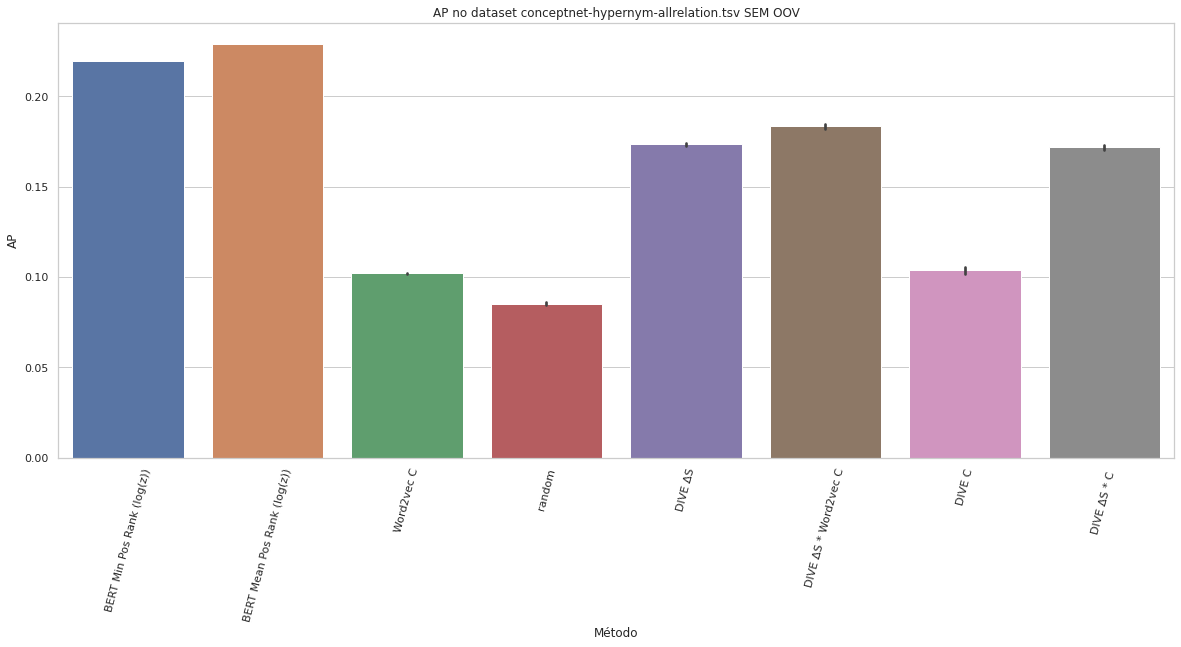

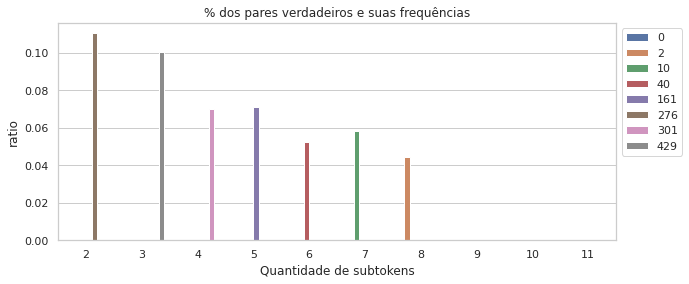

In [17]:
sns.set_theme(style="whitegrid")
best_pattern_without_oov = ['{} ou qualquer outro {}', '{} é um tipo de {}', '{} ou outro {}', '{} ou algum outro {}', '{} e outros {}', '{} e qualquer outro {}', '{} e algum outro {}', '{} , um {}', '{} incluindo {}', '{} é um {}', '{} é um caso especial de {}', '{} que é chamado de {}', '{} que é um tipo de {}', '{} que é um exemplo de {}', '{} que é uma classe de {}']


df_240 = logsumexp_normalization(df_240, len_list=len_total_unique, pattern_list=pattern_unique)
df_240['score_final_log(z)'] = df_240['bert_soma_total'] - df_240['log(Z)']
# df_240['score_final_norm'] = df_240['bert_soma_total'] / df_240['sum_bert_by_tokensize']
print(f"DF 240 True= {df_240[df_240['pattern'] == pattern_unique[0]]['classe'].value_counts()['True']}\n"
      f"False= {df_240[df_240['pattern'] == pattern_unique[0]]['classe'].value_counts()['False']}\n"
      f"% True= {df_240[df_240['pattern'] == pattern_unique[0]]['classe'].value_counts()['True']/(df_240[df_240['pattern'] == pattern_unique[0]]['classe'].value_counts()['True'] + df_240[df_240['pattern'] == pattern_unique[0]]['classe'].value_counts()['False'])}")

dfs = []
dataset_name = path_file_bert.split("/")[-1][:-4] + "tsv"
method_score = ["score_final_log(z)", "score_final_norm"]
best_pattern_num = 4
for score_name in method_score[:1]:
    if score_name == "score_final_log(z)":
        min_ap, mean_ap = compute_AP_by_rank(df_240, key_sort=score_name, best_patterns=best_pattern_without_oov[:best_pattern_num])
    elif score_name == "score_final_norm":
        min_ap, mean_ap = compute_AP_by_rank(df_240, key_sort=score_name, best_patterns=best_pattern_without_oov[:best_pattern_num])
    n_pair = df_240.groupby('pattern').count().iloc[0]['hiponimo']
    hyper_num = df_240[df_240['pattern'] == pattern_unique[0]]['fonte'].value_counts()
    hyper_num = hyper_num['hyper']
    df = pd.DataFrame({'dataset': [dataset_name], 'N': [n_pair], 'hyper_num': [hyper_num], 'method': f"min {score_name}", 'AP': [min_ap]})
    dfs.append(df)
    df = pd.DataFrame({'dataset': [dataset_name], 'N': [n_pair], 'hyper_num': [hyper_num], 'method': f"mean {score_name}", 'AP': [mean_ap]})
    dfs.append(df)

df = pd.concat(dfs)

df_all = pd.concat([df, df_dive_word2vec])
df_all['method_format'] = df_all['method'].map(method_names)
datasetnames_unique = df_all['dataset'].unique().tolist()
rename_dataset = {}
for k in datasetnames_unique:
    rename_dataset[k] = os.path.basename(k)

df_all['dataset'] = df_all['dataset'].map(rename_dataset)

df_ratio = balanceamento(df_240, len_size=len_total_unique[:-2])

# df dive-word2vec 240 sem OOV
df_plot = df_all[df_all['dataset'] == dataset_name]

plt.figure(figsize=(20,8))
ax = sns.barplot(x="method_format", y="AP", data=df_plot)
ax.set(xlabel="Método")
ax.set_title(f"AP no dataset {dataset_name} SEM OOV")
plt.xticks(rotation=75)

plt.figure(figsize=(10,4))
ax = sns.barplot(x="len_total", y="ratio", hue="true", data=df_ratio)
ax.set(xlabel="Quantidade de subtokens")
ax.set_title(f"% dos pares verdadeiros e suas frequências")

ax.legend(bbox_to_anchor=(1, 1))


## Comparando BERT com DIVE e Word2Vec COM OOV

### Dataset conceptnet-all-relation
- Usando Wikipedia240M
- N= 30474
- Usando 4 melhores padrões

DF 240 True= 2323
False= 28151
% True= 0.07622891645337009


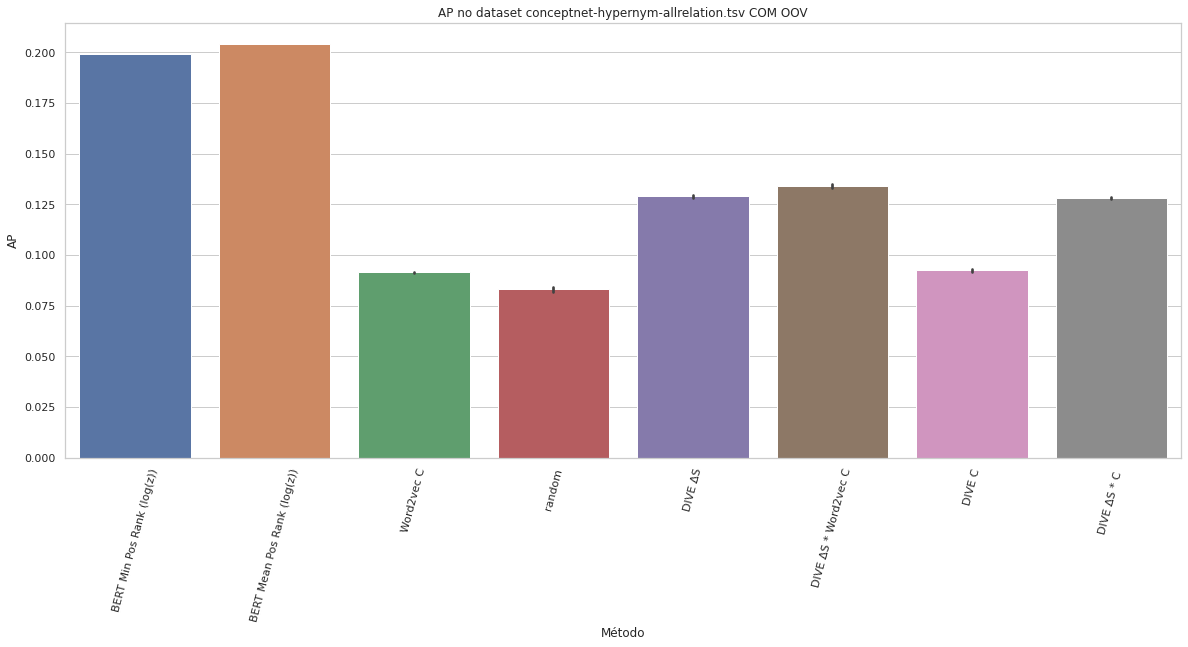

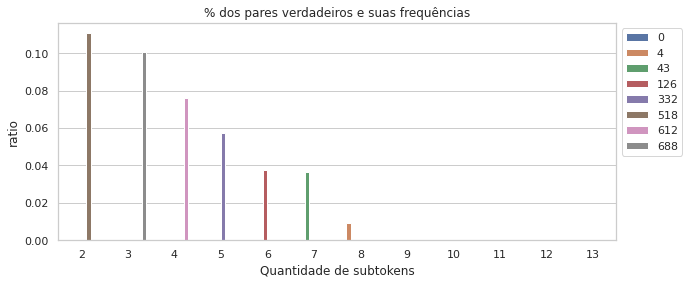

In [18]:
print(f"DF 240 True= {df_with_oov[df_with_oov['pattern'] == pattern_unique[0]]['classe'].value_counts()['True']}\n"
      f"False= {df_with_oov[df_with_oov['pattern'] == pattern_unique[0]]['classe'].value_counts()['False']}\n"
      f"% True= {df_with_oov[df_with_oov['pattern'] == pattern_unique[0]]['classe'].value_counts()['True']/(df_with_oov[df_with_oov['pattern'] == pattern_unique[0]]['classe'].value_counts()['True'] + df_with_oov[df_with_oov['pattern'] == pattern_unique[0]]['classe'].value_counts()['False'])}")

# usar df_with_oov
best_pattern_with_oov = ['{} ou qualquer outro {}', '{} é um tipo de {}', '{} ou outro {}', '{} ou algum outro {}', '{} e outros {}', '{} e qualquer outro {}', '{} e algum outro {}', '{} , um {}', '{} incluindo {}', '{} é um {}', '{} é um caso especial de {}', '{} que é chamado de {}', '{} que é um tipo de {}', '{} que é um exemplo de {}', '{} que é uma classe de {}']

dfs = []
for score_name in method_score[:1]:
    if score_name == "score_final_log(z)":
        min_ap, mean_ap = compute_AP_by_rank(df_with_oov, key_sort=score_name, best_patterns=best_pattern_with_oov[:best_pattern_num])
    elif score_name == "score_final_norm":
        min_ap, mean_ap = compute_AP_by_rank(df_with_oov, key_sort=score_name, best_patterns=best_pattern_with_oov[:best_pattern_num])
    n_pair = df_with_oov.groupby('pattern').count().iloc[0]['hiponimo']
    hyper_num = df_with_oov[df_with_oov['pattern'] == pattern_unique[0]]['fonte'].value_counts()
    hyper_num = hyper_num['hyper']
    df = pd.DataFrame({'dataset': [dataset_name], 'N': [n_pair], 'hyper_num': [hyper_num], 'method': f"min {score_name}", 'AP': [min_ap]})
    dfs.append(df)
    df = pd.DataFrame({'dataset': [dataset_name], 'N': [n_pair], 'hyper_num': [hyper_num], 'method': f"mean {score_name}", 'AP': [mean_ap]})
    dfs.append(df)

df = pd.concat(dfs)

# df dive-word2vec com oov
df_dive_word2vec_all = pd.read_csv(path_d_w[1], delimiter="\t")
df_dive_word2vec_all = df_dive_word2vec_all[df_dive_word2vec_all['epoch_num'] == 14]
df_all = pd.concat([df, df_dive_word2vec_all])

df_all['method_format'] = df_all['method'].map(method_names)
datasetnames_unique = df_all['dataset'].unique().tolist()
rename_dataset = {}
for k in datasetnames_unique:
    rename_dataset[k] = os.path.basename(k)

df_all['dataset'] = df_all['dataset'].map(rename_dataset)

df_ratio = balanceamento(df_with_oov, len_size=len_total_unique)

# df dive-word2vec 240 com OOV
df_plot = df_all[df_all['dataset'] == dataset_name]

plt.figure(figsize=(20,8))
ax = sns.barplot(x="method_format", y="AP", data=df_plot)
ax.set(xlabel="Método")
ax.set_title(f"AP no dataset {dataset_name} COM OOV")
plt.xticks(rotation=75)

plt.figure(figsize=(10,4))
ax = sns.barplot(x="len_total", y="ratio", hue="true", data=df_ratio)
ax.set(xlabel="Quantidade de subtokens")
ax.set_title(f"% dos pares verdadeiros e suas frequências")

ax.legend(bbox_to_anchor=(1, 1))
